<a href="https://colab.research.google.com/github/ricoprediansyah/CV-FASTER_RCNN_RESNET_COUNT_PALM_TREES_DATATEST_PT_SAMPOERNA_AGRO/blob/main/DATATEST_JPG_FASTER_RCNN_RESNET50_COUNT_PALM_TREES_SAMPOERNA_AGRO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##DATASET

In [ ]:
# Mengecek ketersediaan GPU menggunakan PyTorch dan memilih perangkat (GPU/CPU) untuk eksekusi.
import torch  # Mengimpor library PyTorch

# Mengecek apakah GPU tersedia
if torch.cuda.is_available():
    device = torch.device("cuda")  # Menentukan perangkat untuk GPU
    print('There are %d GPU(s) available.' % torch.cuda.device_count())  # Menampilkan jumlah GPU yang tersedia
    print('We will use the GPU:', torch.cuda.get_device_name(0))  # Menampilkan nama GPU yang akan digunakan
else:
    print('No GPU available, using the CPU instead.')  # Jika tidak ada GPU, menggunakan CPU
    device = torch.device("cpu")  # Menentukan perangkat untuk CPU


There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [ ]:
#import datset untuk TRAIN dari roboflow
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="PZMfN1gExhcqfGkkkd43")
project = rf.workspace("cryospace-yylkk").project("palm-tree-label-200m-splitted")
version = project.version(4)
dataset = version.download("voc")

#import datset untuk TEST dari roboflow
from roboflow import Roboflow
rf = Roboflow(api_key="PZMfN1gExhcqfGkkkd43")
project = rf.workspace("rico-prediansyah").project("crop-palm-rico")
version = project.version(3)
dataset = version.download("voc")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.5/81.5 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 8.1 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Palm-Tree-Label-200m-Splitted-4 in voc:: 100%|██████████| 869/869 [00:01<00:00, 767.75it/s]


loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to crop-palm-rico-3 in voc:: 100%|██████████| 115/115 [00:00<00:00, 4139.91it/s]


In [ ]:
import os  # Untuk berinteraksi dengan sistem file, seperti mengakses, membuat, atau menghapus file/folder
import shutil  # Untuk operasi file tingkat tinggi, seperti menyalin, memindahkan, atau menghapus file dan folder

# Membuat folder tujuan jika belum ada
os.makedirs('/content/images', exist_ok=True)
os.makedirs('/content/annotations', exist_ok=True)
os.makedirs('/content/test_images', exist_ok=True)
os.makedirs('/content/test_annotations', exist_ok=True)

# Daftar folder sumber untuk dua kelompok file
folders_group_1 = [
    '/content/Palm-Tree-Label-200m-Splitted-4/test',
    '/content/Palm-Tree-Label-200m-Splitted-4/train',
    '/content/Palm-Tree-Label-200m-Splitted-4/valid'
]
folders_group_2 = [
    '/content/crop-palm-rico-3/train'
]

# Fungsi untuk memindahkan file berdasarkan ekstensi
def move_files(folders, image_target, annotation_target):
    for folder in folders:
        for filename in os.listdir(folder):
            file_path = os.path.join(folder, filename)

            # Memindahkan file .xml ke folder annotations
            if filename.endswith('.xml'):
                shutil.move(file_path, annotation_target)

            # Memindahkan file .png, .jpg, atau .jpeg ke folder images
            elif filename.endswith(('.png', '.jpg', '.jpeg')):
                shutil.move(file_path, image_target)

# Memindahkan file untuk grup pertama
move_files(folders_group_1, '/content/images', '/content/annotations')

# Memindahkan file untuk grup kedua
move_files(folders_group_2, '/content/test_images', '/content/test_annotations')

In [ ]:
# Import libraries yang digunakan dalam program

import os  # Untuk berinteraksi dengan sistem file (misalnya mengakses folder dan file)
import numpy as np  # Untuk komputasi numerik, seperti manipulasi array
import matplotlib.patches as patches  # Untuk menggambar bentuk geometri seperti kotak pada gambar
import matplotlib.pyplot as plt  # Untuk visualisasi data dan plotting gambar
from bs4 import BeautifulSoup  # Untuk parsing dan mengekstrak data dari file XML atau HTML
from PIL import Image  # Untuk memproses dan membuka gambar (Pillow)
import torchvision  # Untuk pustaka visi komputer yang menyediakan model, dataset, dan transformasi
from torchvision import transforms, datasets, models  # Untuk transformasi gambar, dataset, dan model
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor  # Untuk menggunakan model Faster R-CNN untuk deteksi objek
import time  # Untuk mengukur waktu eksekusi dan operasi terkait waktu

In [ ]:
def generate_box(obj):
   # Mendapatkan nilai koordinat min dan max dari elemen XML dan mengubahnya menjadi angka desimal (float).
    xmin = float(obj.find('xmin').text)
    ymin = float(obj.find('ymin').text)
    xmax = float(obj.find('xmax').text)
    ymax = float(obj.find('ymax').text)

    return [xmin, ymin, xmax, ymax]

In [ ]:
adjust_label = 0

def generate_label(obj):
    # Mengembalikan label 1 untuk class "Palm-Trees"
    if obj.find('name').text == "Palm-Tree":
        return 1 + adjust_label

    # Jika class tidak dikenali, kembalikan 0
    return 0 + adjust_label

In [ ]:
# Fungsi generate_target membaca file XML, mengekstrak informasi kotak pembatas dan label objek,
# lalu mengonversinya ke format tensor PyTorch dan mengembalikannya dalam dictionary.

def generate_target(file):
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, "html.parser")
        objects = soup.find_all("object")

        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))  # Ambil koordinat kotak pembatas.
            labels.append(generate_label(i))  # Ambil label objek.

        boxes = torch.as_tensor(boxes, dtype=torch.float32)  # Konversi kotak ke tensor.
        labels = torch.as_tensor(labels, dtype=torch.int64)  # Konversi label ke tensor.

        target = {"boxes": boxes, "labels": labels}  # Buat dictionary target.

        return target  # Kembalikan dictionary target.

In [ ]:
# Fungsi plot_image_from_output menampilkan gambar dan menggambar kotak pembatas berdasarkan anotasi.

def plot_image_from_output(img, annotation):
    img = img.cpu().permute(1,2,0)  # Mengubah format gambar.
    fig, ax = plt.subplots(1)  # Membuat plot gambar.
    ax.imshow(img)  # Menampilkan gambar.

    # Iterasi melalui kotak pembatas dan menggambar kotak.
    for idx in range(len(annotation["boxes"])):
        xmin, ymin, xmax, ymax = annotation["boxes"][idx]
        color = 'r' if annotation['labels'][idx] == 1 else 'orange'  # Warna kotak berdasarkan label.
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=1, edgecolor=color, facecolor='none')
        ax.add_patch(rect)  # Menambahkan kotak ke gambar.

    plt.show()  # Menampilkan gambar dengan kotak pembatas.


In [ ]:
# Kelas MaskDataset adalah dataset kustom untuk menangani gambar dan mask (label) dengan transformasi yang dapat diterapkan.

class MaskDataset(object):
    def __init__(self, transforms, path):
        '''
        path: jalur ke folder train atau test
        '''
        # Menyimpan path gambar dan transformasi yang akan diterapkan
        self.transforms = transforms
        self.path = path
        self.imgs = list(sorted(os.listdir(self.path)))  # Daftar gambar yang ada di dalam folder path

    def __getitem__(self, idx):  # Metode untuk mendapatkan data pada indeks tertentu
        # Memuat gambar dan mask (label)
        file_image = self.imgs[idx]  # Nama file gambar
        file_label = self.imgs[idx][:-3] + 'xml'  # Nama file label (XML) berdasarkan nama gambar
        img_path = os.path.join(self.path, file_image)  # Path gambar

        if 'test' in self.path:
            label_path = os.path.join("test_annotations/", file_label)  # Jika folder test, path label berbeda
        else:
            label_path = os.path.join("annotations/", file_label)  # Path label untuk training

        img = Image.open(img_path).convert("RGB")  # Memuat gambar dan mengonversinya ke format RGB
        target = generate_target(label_path)  # Menghasilkan target (label) berdasarkan file XML

        if self.transforms is not None:
            img = self.transforms(img)  # Menerapkan transformasi pada gambar jika ada

        return img, target  # Mengembalikan gambar dan target

    def __len__(self):
        return len(self.imgs)  # Mengembalikan jumlah gambar dalam dataset

In [ ]:
# Mendefinisikan transformasi untuk dataset dan mempersiapkan DataLoader untuk pelatihan dan pengujian.

# Mendefinisikan transformasi yang akan diterapkan pada gambar
data_transform = transforms.Compose([  # Menggunakan transforms.Compose untuk menyusun beberapa transformasi
    transforms.ToTensor()  # Mengonversi gambar dari format numpy array ke torch.Tensor
])

# Fungsi collate_fn untuk menyesuaikan batch data dalam DataLoader
def collate_fn(batch):
    return tuple(zip(*batch))  # Menggabungkan batch menjadi tuple yang terpisah untuk gambar dan target

# Membuat objek dataset untuk training dan testing
dataset = MaskDataset(data_transform, 'images/')  # Dataset untuk gambar pelatihan
test_dataset = MaskDataset(data_transform, 'test_images/')  # Dataset untuk gambar pengujian

# Membuat DataLoader untuk dataset pelatihan dan pengujian
data_loader = torch.utils.data.DataLoader(dataset, batch_size=4, collate_fn=collate_fn)  # DataLoader untuk pelatihan
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=2, collate_fn=collate_fn)  # DataLoader untuk pengujian

##LOAD MODEL AND TRAINING

In [ ]:
# Mengonfigurasi model Faster R-CNN dengan backbone ResNet-50

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor  # Mengimpor prediktor untuk mengganti model

def get_model_instance_segmentation(num_classes, max_detections=1000):  # Fungsi untuk menyesuaikan model
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)  # Memuat model yang dipra-latih

    in_features = model.roi_heads.box_predictor.cls_score.in_features  # Mengambil jumlah fitur masukan
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)  # Mengganti prediktor

    model.roi_heads.detections_per_img = max_detections  # Mengatur jumlah deteksi maksimum

    return model  # Mengembalikan model yang telah dikonfigurasi

In [ ]:
# Mengonfigurasi model dan mengatur perangkat (GPU/CPU)

model = get_model_instance_segmentation(2, max_detections=1000)  # Memanggil fungsi untuk mendapatkan model dengan 2 kelas dan 1000 deteksi maksimum
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')  # Menentukan perangkat (GPU jika tersedia, jika tidak CPU)

model.to(device)  # Memindahkan model ke perangkat yang dipilih (GPU/CPU)

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 179MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
# Mengecek apakah GPU tersedia untuk digunakan dengan PyTorch
torch.cuda.is_available()  # Mengembalikan True jika GPU tersedia, False jika tidak

True

In [ ]:
# Menyiapkan optimizer
num_epochs = 15  # Menetapkan jumlah epoch
params = [p for p in model.parameters() if p.requires_grad]# Mengambil parameter yang memerlukan gradien
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005) # Mengonfigurasi optimizer SGD

In [ ]:
# Memulai pelatihan model

print('----------------------train start--------------------------')  # Menampilkan pesan saat pelatihan dimulai
for epoch in range(num_epochs):  # Melakukan iterasi untuk setiap epoch
    start = time.time()  # Mencatat waktu mulai epoch
    model.train()  # Mengatur model ke mode pelatihan
    i = 0  # Inisialisasi counter batch
    epoch_loss = 0  # Inisialisasi total loss per epoch
    for imgs, annotations in data_loader:  # Iterasi untuk setiap batch data
        i += 1
        imgs = list(img.to(device) for img in imgs)  # Memindahkan gambar ke perangkat (GPU/CPU)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]  # Memindahkan anotasi ke perangkat
        loss_dict = model(imgs, annotations)  # Menjalankan model dan menghitung loss
        losses = sum(loss for loss in loss_dict.values())  # Menjumlahkan semua loss

        optimizer.zero_grad()  # Mengatur gradien menjadi nol
        losses.backward()  # Melakukan backpropagation
        optimizer.step()  # Memperbarui parameter model
        epoch_loss += losses  # Menambahkan losses untuk epoch ini
    print(f'epoch : {epoch+1}, Loss : {epoch_loss}, time : {time.time() - start}')  # Menampilkan loss per epoch dan waktu yang dibutuhkan

----------------------train start--------------------------
epoch : 1, Loss : 87.1491470336914, time : 123.8399167060852
epoch : 2, Loss : 66.03934478759766, time : 121.51192736625671
epoch : 3, Loss : 63.20661926269531, time : 121.77622890472412
epoch : 4, Loss : 61.12330627441406, time : 121.85785269737244
epoch : 5, Loss : 59.64952850341797, time : 122.85621380805969
epoch : 6, Loss : 57.90947341918945, time : 121.6710352897644
epoch : 7, Loss : 57.21187210083008, time : 122.02400040626526
epoch : 8, Loss : 56.29622268676758, time : 122.69942092895508
epoch : 9, Loss : 55.89574432373047, time : 121.83387327194214
epoch : 10, Loss : 55.380889892578125, time : 121.31073021888733
epoch : 11, Loss : 54.123172760009766, time : 121.50462651252747
epoch : 12, Loss : 52.81035614013672, time : 118.18204307556152
epoch : 13, Loss : 52.44242477416992, time : 122.22715830802917
epoch : 14, Loss : 51.810211181640625, time : 121.60962414741516
epoch : 15, Loss : 51.78071212768555, time : 122.1384

In [ ]:
torch.save(model.state_dict(),f'model_{num_epochs}.pt') # Menyimpan model setelah pelatihan

In [ ]:
model.load_state_dict(torch.load(f'model_{num_epochs}.pt')) # Memuat model yang telah disimpan

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


<All keys matched successfully>

##TEST AND EVALUATION

In [ ]:
# Fungsi untuk membuat prediksi dengan model deteksi objek

def make_prediction(model, img, threshold):
    model.eval()  # Set model ke mode evaluasi
    preds = model(img)  # Melakukan prediksi dengan model

    # Loop untuk setiap gambar dalam batch prediksi
    for id in range(len(preds)):
        idx_list = []  # Daftar untuk menyimpan indeks prediksi yang memenuhi threshold

        # Loop melalui skor prediksi dan memilih yang lebih tinggi dari threshold
        for idx, score in enumerate(preds[id]['scores']):
            if score > threshold:
                idx_list.append(idx)

        # Menyaring prediksi berdasarkan indeks yang memenuhi threshold
        preds[id]['boxes'] = preds[id]['boxes'][idx_list]
        preds[id]['labels'] = preds[id]['labels'][idx_list]
        preds[id]['scores'] = preds[id]['scores'][idx_list]

    return preds  # Mengembalikan hasil prediksi yang disaring

In [ ]:
# Melakukan prediksi tanpa menghitung gradien (untuk efisiensi memori)

with torch.no_grad():  # Menonaktifkan perhitungan gradien, karena kita hanya memprediksi (bukan melatih)
    # batch size dari data uji = 2
    for imgs, annotations in test_data_loader:  # Loop melalui batch gambar di data loader
        imgs = list(img.to(device) for img in imgs)  # Memindahkan gambar ke perangkat (CPU atau GPU)

        # Membuat prediksi dengan model menggunakan ambang batas 0.5
        pred = make_prediction(model, imgs, 0.5)
        print(pred)  # Menampilkan hasil prediksi
        break  # Hanya memproses satu batch pertama, kemudian keluar dari loop

[{'boxes': tensor([[424.6562, 486.2675, 496.8476, 579.7816],
        [486.9691, 448.1966, 569.5522, 532.7048],
        [559.5684, 493.5677, 640.0000, 580.0258],
        [265.3381, 145.3129, 346.6159, 224.7871],
        [190.3235, 539.2538, 270.6960, 610.1516],
        [343.6174, 445.7549, 425.7525, 536.5881],
        [266.9802, 493.4577, 353.5341, 576.7267],
        [263.5159, 319.7880, 350.6705, 401.9767],
        [493.8329, 270.0345, 570.8603, 355.1149],
        [422.2721, 313.9084, 496.9585, 392.8172],
        [558.1633,  49.4668, 636.7480, 133.8706],
        [342.1093, 273.7735, 418.4971, 363.6103],
        [485.1788, 361.0072, 578.7246, 438.8350],
        [561.3964, 319.5764, 640.0000, 397.3718],
        [562.3160, 394.1694, 640.0000, 497.4601],
        [488.4237, 181.8793, 573.8873, 263.8354],
        [118.8351, 236.2704, 184.4912, 320.6275],
        [414.4799,  57.9699, 490.3398, 131.0718],
        [266.3938, 410.3838, 351.6353, 499.3337],
        [415.4179, 140.0347, 496.3801, 

Target (Ground Truth):  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


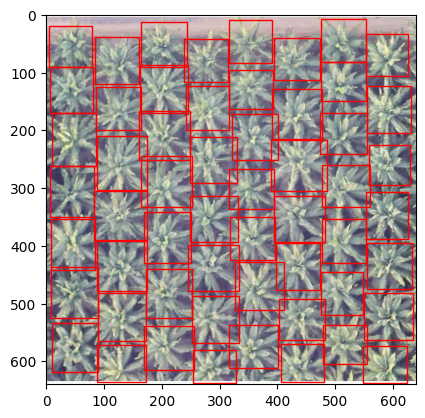

Prediction:  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


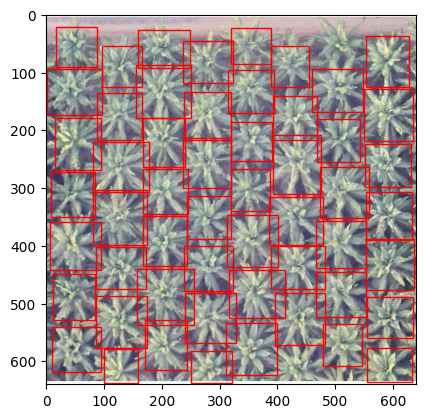

Jumlah label ground truth: 56
Jumlah label hasil prediksi: 54
Accuracy: 96.43%


In [ ]:
# Tentukan threshold untuk confidence score
threshold = 0.5
_idx = 1 # GPU index untuk data yang digunakan

print("Target (Ground Truth): ", annotations[_idx]['labels'].cpu().numpy())  # Pindahkan labels ke CPU sebelum dicetak

imgs_cpu = imgs[_idx].cpu() # Pindahkan gambar ke CPU untuk visualisasi
annotations_cpu = {k: v.cpu().numpy() for k, v in annotations[_idx].items()} # Pindahkan setiap tensor di dalam annotations (ground truth) ke CPU
plot_image_from_output(imgs_cpu, annotations_cpu) # Visualisasikan gambar dan anotasi (ground truth)
pred_cpu = {k: v.cpu().numpy() for k, v in pred[_idx].items()} # Pindahkan prediksi ke CPU

# Visualisasikan gambar dan prediksi
print("Prediction: ", pred_cpu['labels'])
plot_image_from_output(imgs_cpu, pred_cpu)

# Hitung label ground truth dan prediksi
ground_truth_labels = annotations[_idx]['labels'].cpu().numpy()
predicted_labels = pred_cpu['labels']

# Filter prediksi berdasarkan threshold
valid_indices = np.where(pred_cpu['scores'] >= threshold)[0]
predicted_labels = predicted_labels[valid_indices]

# Jumlah label asli (ground truth) dan hasil prediksi
print(f"Jumlah label ground truth: {len(ground_truth_labels)}")
print(f"Jumlah label hasil prediksi: {len(predicted_labels)}")

# Menghitung akurasi dengan membagi jumlah label hasil prediksi dengan jumlah label ground truth
accuracy = len(predicted_labels) / len(ground_truth_labels) * 100 if len(ground_truth_labels) > 0 else 0
print(f"Accuracy: {accuracy:.2f}%")

In [ ]:
# Import tqdm untuk progress bar
from tqdm import tqdm

# Inisialisasi variabel untuk menyimpan hasil
labels = []
preds_adj_all = []
annot_all = []

# Loop untuk setiap batch pada test_data_loader
for im, annot in tqdm(test_data_loader, position = 0, leave = True):
    im = list(img.to(device) for img in im) # Pindahkan gambar ke device (GPU/CPU)

    # Ambil label dari anotasi
    for t in annot:
        labels += t['labels']

    # Lakukan prediksi tanpa menghitung gradien
    with torch.no_grad():
        preds_adj = make_prediction(model, im, 0.5) # Prediksi gambar dengan threshold 0.5
        preds_adj = [{k: v.to(torch.device('cpu')) for k, v in t.items()} for t in preds_adj] # Pindahkan hasil prediksi ke CPU

        # Simpan prediksi dan anotasi untuk analisis lebih lanjut
        preds_adj_all.append(preds_adj)
        annot_all.append(annot)

100%|██████████| 28/28 [00:07<00:00,  3.57it/s]


In [ ]:
!git clone https://github.com/Pseudo-Lab/Tutorial-Book-Utils #download library Book Utils

Cloning into 'Tutorial-Book-Utils'...
remote: Enumerating objects: 45, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 45 (delta 18), reused 19 (delta 5), pack-reused 0 (from 0)
Receiving objects: 100% (45/45), 11.63 KiB | 3.88 MiB/s, done.
Resolving deltas: 100% (18/18), done.


In [ ]:
!mv /content/Tutorial-Book-Utils/utils_ObjectDetection.py /content/ #mengatur folder library

In [ ]:
import utils_ObjectDetection as utils

# Menghitung True Positives, pred_scores, dan pred_labels dari batch statistics
sample_metrics = []
for batch_i in range(len(preds_adj_all)):
    sample_metrics += utils.get_batch_statistics(preds_adj_all[batch_i], annot_all[batch_i], iou_threshold=0.5)

true_positives, pred_scores, pred_labels = [torch.cat(x, 0) for x in list(zip(*sample_metrics))]

# Menghitung Precision, Recall, dan F1 Score
precision, recall, ap, f1, ap_class = utils.ap_per_class(true_positives, pred_scores, pred_labels, torch.tensor(labels))

# Menghitung Akurasi
total_detections = true_positives.shape[0]  # Jumlah semua prediksi (TP + FP)
TP_sum = true_positives.sum()  # Jumlah True Positives
accuracy = TP_sum / total_detections  # Akurasi = TP / (TP + FP)

# Output hasil evaluasi
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1}')
print(f'Accuracy: {accuracy.item()}')

Precision: tensor([0.9658])
Recall: tensor([0.8109])
F1-score: tensor([0.8816])
Accuracy: 0.9657649993896484


In [ ]:
sample_metrics = []

# Loop untuk menghitung statistik per batch
for batch_i in range(len(preds_adj_all)):
    sample_metrics += utils.get_batch_statistics(preds_adj_all[batch_i], annot_all[batch_i], iou_threshold=0.5)

# Gabungkan hasil true positives, skor prediksi, dan label
true_positives, pred_scores, pred_labels = [torch.cat(x, 0) for x in list(zip(*sample_metrics))]

# Hitung precision, recall, AP, F1, dan AP per class
precision, recall, AP, f1, ap_class = utils.ap_per_class(true_positives, pred_scores, pred_labels, torch.tensor(labels))

# Hitung mAP
mAP = torch.mean(AP)

# Cetak mAP dan AP
print(f'mAP : {mAP}')
print(f'AP : {AP}')

mAP : 0.7946972309281337
AP : tensor([0.7947], dtype=torch.float64)


In [ ]:
# Hitung True Positives, pred_scores, dan pred_labels dari batch statistics
sample_metrics = []
for batch_i in range(len(preds_adj_all)):
    sample_metrics += utils.get_batch_statistics(preds_adj_all[batch_i], annot_all[batch_i], iou_threshold=0.5)

true_positives, pred_scores, pred_labels = [torch.cat(x, 0) for x in list(zip(*sample_metrics))]

# Menghitung Precision, Recall, dan F1 Score
precision, recall, ap, f1, ap_class = utils.ap_per_class(true_positives, pred_scores, pred_labels, torch.tensor(labels))

# Menghitung Akurasi
total_detections = true_positives.shape[0]  # Jumlah semua prediksi (TP + FP)
TP_sum = true_positives.sum()  # Jumlah True Positives
accuracy = TP_sum / total_detections if total_detections > 0 else 0  # Akurasi = TP / (TP + FP)


# Menghitung Mean Squared Error (MSE) dan Root Mean Squared Error (RMSE)
def calculate_mse_rmse(pred_scores, true_labels):
    """ Menghitung MSE dan RMSE """
    if len(pred_scores) != len(true_labels):
        raise ValueError("Jumlah prediksi dan jumlah label harus sama.")

    # Menghitung MSE
    mse = torch.mean((pred_scores - true_labels) ** 2)
    rmse = torch.sqrt(mse)

    return mse.item(), rmse.item()

# Filter pred_scores dan true_labels untuk memastikan ukurannya sama
valid_indices = true_positives.nonzero(as_tuple=True)[0]  # Ambil indeks True Positives

# Memastikan filtered_pred_scores dan filtered_true_labels memiliki ukuran yang sama
if len(valid_indices) > 0:
    filtered_pred_scores = pred_scores[valid_indices]

    # Ambil true labels yang sesuai dengan pred_labels
    filtered_true_labels = pred_labels[valid_indices]

    # Hitung MSE dan RMSE
    mse, rmse = calculate_mse_rmse(filtered_pred_scores, filtered_true_labels)

    # Output hasil MSE dan RMSE
    print(f'Mean Squared Error (MSE): {mse}')
    print(f'Root Mean Squared Error (RMSE): {rmse}')
else:
    print("Tidak ada True Positives yang ditemukan.")

Mean Squared Error (MSE): 0.012523369863629341
Root Mean Squared Error (RMSE): 0.11190786212682724
